>![Google's logo](https://logodownload.org/wp-content/uploads/2014/09/lol-league-of-Legends-logo-2-1.png)

# Selección del conjunto de datos

In [ ]:
!pip install statsmodels
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import math
from statsmodels.formula.api import ols

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Para este proyecto vamos a utilizar un conjunto de datos con todas las partidas de las principales ligas a nivel internacional de la escena de league of legends, para esto utilizaremos los datos que se ofrecen de manera pública y gratuita en la web de Oracle's Elixir (https://oracleselixir.com/):

In [ ]:
all_games = pd.read_csv("https://oracleselixir-downloadable-match-data.s3-us-west-2.amazonaws.com/2020_LoL_esports_match_data_from_OraclesElixir_20201220.csv")
all_games.head(5)

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,...,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15
0,ESPORTSTMNT03/1241318,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1,9.24,1,Blue,top,Summit,SANDBOX Gaming,Rumble,LeBlanc,Irelia,Rek'Sai,Yasuo,Renekton,2220,1,0,3,7,17,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4595,0.7568,NaN,NaN,...,0.198651,464.6216,488.2162,23,0.6216,3,0.0811,10,35.0,0.9459,13302,8498,229.6757,0.189235,11350.0,NaN,285.0,276.0,9,5,0,7.7027,3348.0,4864.0,88.0,2845.0,4432.0,65.0,503.0,432.0,23.0,4888.0,7368.0,131.0,4723.0,7202.0,118.0,165.0,166.0,13.0
1,ESPORTSTMNT03/1241318,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1,9.24,2,Blue,jng,OnFleek,SANDBOX Gaming,Elise,LeBlanc,Irelia,Rek'Sai,Yasuo,Renekton,2220,1,4,0,9,17,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4595,0.7568,NaN,NaN,...,0.145393,541.0541,289.1351,47,1.2703,26,0.7027,17,102.0,2.7568,13484,8680,234.5946,0.193288,12175.0,NaN,210.0,40.0,170,130,0,5.6757,2895.0,2887.0,57.0,3093.0,3010.0,67.0,-198.0,-123.0,-10.0,4385.0,4817.0,91.0,4784.0,4667.0,98.0,-399.0,150.0,-7.0
2,ESPORTSTMNT03/1241318,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1,9.24,3,Blue,mid,FATE,SANDBOX Gaming,Qiyana,LeBlanc,Irelia,Rek'Sai,Yasuo,Renekton,2220,1,5,2,5,17,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4595,0.7568,NaN,NaN,...,0.223947,372.4865,243.2162,39,1.0541,32,0.8649,7,99.0,2.6757,15419,10615,286.8919,0.236379,14225.0,NaN,320.0,312.0,8,2,0,8.6486,3110.0,4153.0,80.0,3261.0,4861.0,89.0,-151.0,-708.0,-9.0,4809.0,6275.0,129.0,5218.0,8112.0,140.0,-409.0,-1837.0,-11.0
3,ESPORTSTMNT03/1241318,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1,9.24,4,Blue,bot,Leo,SANDBOX Gaming,Miss Fortune,LeBlanc,Irelia,Rek'Sai,Yasuo,Renekton,2220,1,7,1,9,17,11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4595,0.7568,NaN,NaN,...,0.378712,245.6216,657.4595,20,0.5405,30,0.8108,8,66.0,1.7838,18883,14079,380.5135,0.313520,16500.0,NaN,420.0,391.0,29,29,0,11.3514,3297.0,3233.0,93.0,3300.0,3250.0,90.0,-3.0,-17.0,3.0,4915.0,4959.0,136.0,4864.0,5360.0,135.0,51.0,-401.0,1.0
4,ESPORTSTMNT03/1241318,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1,9.24,5,Blue,sup,GorillA,SANDBOX Gaming,Nautilus,LeBlanc,Irelia,Rek'Sai,Yasuo,Renekton,2220,1,1,5,3,17,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4595,0.7568,NaN,NaN,...,0.053296,351.5405,624.4324,62,1.6757,6,0.1622,25,78.0,2.1081,7839,3035,82.0270,0.067578,8025.0,NaN,30.0,30.0,0,0,0,0.8108,1965.0,2708.0,12.0,1999.0,2429.0,11.0,-34.0,279.0,1.0,2956.0,3800.0,20.0,3189.0,3543.0,28.0,-233.0,257.0,-8.0


Primero que nada vamos a eliminar todos los campos irrelevantes para el análisis y los que nos den información demasiado especifica de partida:

In [ ]:
games = all_games.drop(columns=["gameid","datacompleteness","url","playerid","game","playoffs","ban1","ban2","ban3","ban4","ban5","split"])
games = games.drop(columns=["doublekills","triplekills","quadrakills","pentakills","firstblood","firstbloodkill","firstbloodassist","firstbloodvictim","team kpm",
                                    "ckpm","firstdragon","opp_dragons","elementaldrakes","opp_elementaldrakes","infernals","mountains","clouds","oceans","dragons (type unknown)",
                                    "elders","opp_elders","firstherald","opp_heralds","firstbaron","opp_barons","firsttower","opp_towers","firstmidtower","firsttothreetowers",
                                    "opp_inhibitors","controlwardsbought","earnedgold","goldspent","gspd","minionkills","monsterkills","monsterkillsownjungle",
                                    "monsterkillsenemyjungle","goldat10","xpat10","csat10","opp_goldat10","opp_xpat10","opp_csat10","golddiffat10","xpdiffat10","csdiffat10","goldat15",
                                    "xpat15","csat15","opp_goldat15","opp_xpat15","opp_csat15","golddiffat15","xpdiffat15","csdiffat15","damagemitigatedperminute",
                                    "wcpm","damagetakenperminute","dragons","heralds","barons","towers","inhibitors"])
games.head(5)

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
0,KeSPA,2020,2020-01-03 07:33:26,9.24,Blue,top,Summit,SANDBOX Gaming,Rumble,2220,1,0,3,7,17,11,15431,417.0541,0.198651,23,0.6216,3,35.0,0.9459,13302,229.6757,0.189235,285.0,7.7027
1,KeSPA,2020,2020-01-03 07:33:26,9.24,Blue,jng,OnFleek,SANDBOX Gaming,Elise,2220,1,4,0,9,17,11,11294,305.2432,0.145393,47,1.2703,26,102.0,2.7568,13484,234.5946,0.193288,210.0,5.6757
2,KeSPA,2020,2020-01-03 07:33:26,9.24,Blue,mid,FATE,SANDBOX Gaming,Qiyana,2220,1,5,2,5,17,11,17396,470.1622,0.223947,39,1.0541,32,99.0,2.6757,15419,286.8919,0.236379,320.0,8.6486
3,KeSPA,2020,2020-01-03 07:33:26,9.24,Blue,bot,Leo,SANDBOX Gaming,Miss Fortune,2220,1,7,1,9,17,11,29418,795.0811,0.378712,20,0.5405,30,66.0,1.7838,18883,380.5135,0.313520,420.0,11.3514
4,KeSPA,2020,2020-01-03 07:33:26,9.24,Blue,sup,GorillA,SANDBOX Gaming,Nautilus,2220,1,1,5,3,17,11,4140,111.8919,0.053296,62,1.6757,6,78.0,2.1081,7839,82.0270,0.067578,30.0,0.8108


Despues de limpiar los campos con los que no vamos a trabajar, eliminaremos las partidas a las que les falte información y las que no formen parte de las ligas que vamos a analizar (ademas de añadir las partidas de las ligas no regulares a sus respectivas ligas):

In [ ]:
games = games.dropna()
# filtrado
main_leagues = ['KeSPA', 'LPL', 'LEC', 'LCS', 'LCK']
games = games[ games['league'].isin(main_leagues)]
# agrupamos datos de ligas
games.loc[games['league'] == "KeSPA", 'league'] = "LCK"

games.head(5)

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
0,LCK,2020,2020-01-03 07:33:26,9.24,Blue,top,Summit,SANDBOX Gaming,Rumble,2220,1,0,3,7,17,11,15431,417.0541,0.198651,23,0.6216,3,35.0,0.9459,13302,229.6757,0.189235,285.0,7.7027
1,LCK,2020,2020-01-03 07:33:26,9.24,Blue,jng,OnFleek,SANDBOX Gaming,Elise,2220,1,4,0,9,17,11,11294,305.2432,0.145393,47,1.2703,26,102.0,2.7568,13484,234.5946,0.193288,210.0,5.6757
2,LCK,2020,2020-01-03 07:33:26,9.24,Blue,mid,FATE,SANDBOX Gaming,Qiyana,2220,1,5,2,5,17,11,17396,470.1622,0.223947,39,1.0541,32,99.0,2.6757,15419,286.8919,0.236379,320.0,8.6486
3,LCK,2020,2020-01-03 07:33:26,9.24,Blue,bot,Leo,SANDBOX Gaming,Miss Fortune,2220,1,7,1,9,17,11,29418,795.0811,0.378712,20,0.5405,30,66.0,1.7838,18883,380.5135,0.313520,420.0,11.3514
4,LCK,2020,2020-01-03 07:33:26,9.24,Blue,sup,GorillA,SANDBOX Gaming,Nautilus,2220,1,1,5,3,17,11,4140,111.8919,0.053296,62,1.6757,6,78.0,2.1081,7839,82.0270,0.067578,30.0,0.8108


Por último, como el tamaño de los datos es demasiado grande, vamos a hacer un muestreo estratificado aleatorio para obtener un total de 1000 muestras con las que trabajar.

In [ ]:
games_sample = games.groupby('league', group_keys=False).apply(lambda x: x.sample(int(np.rint(1000*len(x)/len(games))))).sample(frac=1).reset_index(drop=True)
games_sample.shape

(1001, 29)

In [ ]:
print("LEC games -> " , games_sample[(games_sample['league'] == "LEC")]['league'].count())
print("LCK games -> " , games_sample[(games_sample['league'] == "LCK")]['league'].count())
print("LPL games -> " , games_sample[(games_sample['league'] == "LPL")]['league'].count())
print("LCS games -> " , games_sample[(games_sample['league'] == "LCS")]['league'].count())

LEC games ->  141
LCK games ->  282
LPL games ->  424
LCS games ->  154


In [ ]:
games_sample.head(5)

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
0,LPL,2020,2020-06-07 12:59:00,10.11,Red,mid,FoFo,Bilibili Gaming,Twisted Fate,1809,0,0,4,6,6,15,12864,426.6667,0.228669,16,0.5307,2,16.0,0.5307,9714,190.6468,0.200811,202.0,6.6998
1,LCK,2020,2020-07-01 08:47:25,10.12,Blue,sup,BeryL,DAMWON Gaming,Thresh,2952,1,3,2,6,12,8,2951,59.9797,0.032232,94,1.9106,26,160.0,3.2520,11104,97.6829,0.087776,47.0,0.9553
2,LPL,2020,2020-01-14 11:21:00,10.01,Red,sup,LvMao,JD Gaming,Nautilus,1666,1,0,2,11,16,5,3783,136.2425,0.075920,42,1.5126,13,66.0,2.3770,6444,99.7599,0.079193,33.0,1.1885
3,LCK,2020,2020-06-19 08:49:01,10.11,Blue,mid,Dove,SANDBOX Gaming,Azir,1449,0,3,7,0,7,24,12578,520.8282,0.300959,11,0.4555,3,22.0,0.9110,9966,278.8406,0.305636,231.0,9.5652
4,LCK,2020,2020-06-19 08:49:01,10.11,Blue,sup,GorillA,SANDBOX Gaming,Thresh,1449,0,0,6,6,7,24,2218,91.8427,0.053071,34,1.4079,4,48.0,1.9876,5160,79.8344,0.087520,24.0,0.9938


# Descripción de los datos

Para este proyecto hemos elegido un conjunto de datos del famoso videojuego del género multijugador de arena de batalla en línea League of Legends.
El juego se basa en que dos equipos de 5 jugadores se enfrentan en una batalla la cual termina cuando uno de los dos equipos destruye todas las defensas enemigas.

Nosotros vamos a centrarnos en las diferencias que podemos encontrar entre las diferentes grandes ligas a nivel internacional y las diferencias en estilo de juego de estos en cada uno de las versiones del juego (el juego recibe cambios cada cierto tiempo en lo que se conocen como parches/versiones).

Para realizar todo esto hemos seleccionado un conjunto de datos con todas las partidas jugadas en 2020 en las grandes ligas China (LPL), Coreana (LCK), Europea (LEC) y Norteamericana (LCS). Estos datos fueron extraidos de (https://oracleselixir.com/) y preparados para su uso.

Las variables aleatorias utilizadas para esto son:


*   league (liga) [categórica]
*   position (rol en partida) [categórica]
*   gamelength (duración de la partida) [continua]
*   vspm (puntuación de visión por minuto, calculada por la suma de los minutos que ha otorgado a su equipo o denegado visión al enemigo entre todos los minutos de partida) [continua]
*   dpm (daño inflingido por minuto) [continua]
*   total cs (subditos eliminados en partida) [discreta]



In [ ]:
games_sample

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
0,LPL,2020,2020-06-07 12:59:00,10.11,Red,mid,FoFo,Bilibili Gaming,Twisted Fate,1809,0,0,4,6,6,15,12864,426.6667,0.228669,16,0.5307,2,16.0,0.5307,9714,190.6468,0.200811,202.0,6.6998
1,LCK,2020,2020-07-01 08:47:25,10.12,Blue,sup,BeryL,DAMWON Gaming,Thresh,2952,1,3,2,6,12,8,2951,59.9797,0.032232,94,1.9106,26,160.0,3.2520,11104,97.6829,0.087776,47.0,0.9553
2,LPL,2020,2020-01-14 11:21:00,10.01,Red,sup,LvMao,JD Gaming,Nautilus,1666,1,0,2,11,16,5,3783,136.2425,0.075920,42,1.5126,13,66.0,2.3770,6444,99.7599,0.079193,33.0,1.1885
3,LCK,2020,2020-06-19 08:49:01,10.11,Blue,mid,Dove,SANDBOX Gaming,Azir,1449,0,3,7,0,7,24,12578,520.8282,0.300959,11,0.4555,3,22.0,0.9110,9966,278.8406,0.305636,231.0,9.5652
4,LCK,2020,2020-06-19 08:49:01,10.11,Blue,sup,GorillA,SANDBOX Gaming,Thresh,1449,0,0,6,6,7,24,2218,91.8427,0.053071,34,1.4079,4,48.0,1.9876,5160,79.8344,0.087520,24.0,0.9938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,LEC,2020,2020-08-01 14:53:06,10.15,Blue,mid,Special,Excel Esports,Orianna,1995,1,0,2,5,10,5,12561,377.7744,0.235728,18,0.5414,4,32.0,0.9624,13454,273.9549,0.220446,315.0,9.4737
997,LPL,2020,2020-08-25 10:24:00,10.16,Red,sup,SwordArt,Suning,Thresh,2066,1,0,1,12,20,10,3572,103.7367,0.040083,49,1.4230,12,95.0,2.7590,7998,101.8780,0.081917,33.0,0.9584
998,LCK,2020,2020-07-30 08:34:35,10.14,Blue,jng,Haru,Hanwha Life Esports,Nidalee,1476,0,1,6,2,4,16,7652,311.0569,0.226003,22,0.8943,6,39.0,1.5854,7268,161.8293,0.190780,136.0,5.5285
999,LPL,2020,2020-08-05 09:19:00,10.15,Red,sup,Mark,LGD Gaming,Bard,1684,0,0,2,2,3,19,2530,90.1425,0.062860,64,2.2803,12,95.0,3.3848,5795,74.2518,0.088314,35.0,1.2470


# Análisis descriptivo

Para el análisis descriptivo vamos a comenzar observando las variables continuas y discretas que hemos elegido:

## Duración de partidas (variable continua)

Comenzamos con la duración de las partidas, podemos observar que la media de duración está en 1972.5 segundos (unos 33 minutos), bastante coherente ya que gran parte de la temporada ha tenido un estilo de juego muy lento ya que la mayoria de personajes necesitaba de muchos recursos para poder llegar a tener un buen impacto en partida.

Encontramos que la mayoria de las muestras se encuentran entre 1727.5 (28.8 minutos) y 2157 (35.95 minutos) (primer y tercer percentil), cosa que tiene sentido como hemos comentado anteriormente.

Si nos fijamos en la asimetría, el coeficiente de asimetría estandarizado y la cercania de la mediana con la media que se trata de una distribución bastante simétrica.

Por otro lado, si observamos la curtosis estandarizada, vemos que se trata de una distribución un tanto leptocúrtica y que segun la curtosis se desvia un poco de la normal.

Mirando el histograma, parece que la distribución que se asemeja a una normal, cosa que con la asimetría y curtosis nos dice tambien.

Asimetría ->  0.7419445199597708
Curtosis ->  0.9051695326268128
count    1001.000000
mean     1983.048951
std       356.736433
min      1014.000000
25%      1738.000000
50%      1950.000000
75%      2176.000000
max      3680.000000
Name: gamelength, dtype: float64


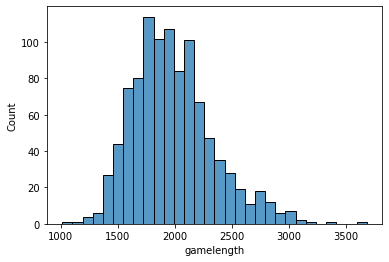

In [ ]:
# gamelength
print("Asimetría -> ",games_sample['gamelength'].skew())
print("Curtosis -> ",games_sample['gamelength'].kurt())
print(games_sample['gamelength'].describe())
sns.histplot(data=games_sample, x="gamelength", bins=30)

Observando el diagrama Box-Whisker, parece ser que es una distribución simétrica y con una cierta normalidad, de todas formas se observan ciertos valores un tanto alejados.

De todas formas, estos datos que vemos simplemente deben tratarse de partidas con composiciones que escalaban muy lento con el tiempo, como por ejemplo pasa con el mayor valor que encontramos, partida de Inmortals que está catalogada como la partida más larga de la LCS Norteamericana en 2020 con 61.20 minutos, esto nos dice que todos estos valores más perifericos simplemente se deben partidas un tanto peculiares, de hecho en ningun caso estas muestras superan el 5% del total de muestras (menos en la LCS norteamericana, la cual llega a contar con un 10% de partidas más largas, una de tantas razones por las que se considera esta liga como inferior respecto a las demas).

muestras totales:  1001
LPL :  424
LCK :  282
LCS :  154
LEC :  141

muestras < 1200:  2
LCK :  1
LPL :  1

muestras > 2700:  48
LCK :  14
LCS :  12
LPL :  12
LEC :  10

muestras (>1200) & (<2700):  951
LPL :  411
LCK :  267
LCS :  142
LEC :  131


,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
248,LCS,2020,2020-01-26 20:35:10,10.01,Red,bot,Altec,Immortals,Ezreal,3680,1,4,0,2,9,9,49118,800.8370,0.387708,26,0.4239,24,69.0,1.125,24942,279.7663,0.297675,556.0,9.0652
928,LCS,2020,2020-03-29 00:41:46,10.06,Red,sup,aphromoo,Dignitas,Nautilus,3406,1,2,5,8,13,15,9108,160.4463,0.072761,82,1.4445,16,138.0,2.431,12628,95.1967,0.093293,50.0,0.8808


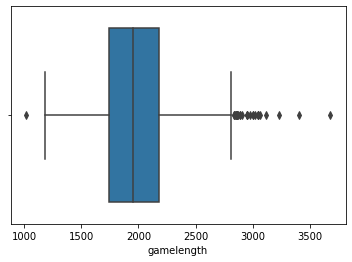

In [ ]:
sns.boxplot( x=games_sample.gamelength )

print("muestras totales: ",games_sample['gamelength'].count())
for x in list(pd.unique(games_sample['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x)]['gamelength'].count())

print("")
print("muestras < 1200: ", games_sample[games_sample['gamelength'] < 1200]['gamelength'].count())
# print(pd.unique(games_sample[games_sample['gamelength'] < 1200]['league']))
for x in list(pd.unique(games_sample[games_sample['gamelength'] < 1200]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['gamelength'] < 1200)]['gamelength'].count())

print("")
print("muestras > 2700: ",games_sample[games_sample['gamelength'] > 2700]['gamelength'].count())
# print(pd.unique(games_sample[games_sample['gamelength'] > 2700]['league']))
for x in list(pd.unique(games_sample[games_sample['gamelength'] > 2700]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['gamelength'] > 2700)]['gamelength'].count())

print("")
print("muestras (>1200) & (<2700): ",games_sample[(games_sample['gamelength'] < 2700) & (games_sample['gamelength'] > 1200)]['gamelength'].count())
for x in list(pd.unique(games_sample[(games_sample['gamelength'] < 2700) & (games_sample['gamelength'] > 1200)]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['gamelength'] < 2700) & (games_sample['gamelength'] > 1200)]['gamelength'].count())

games_sample[(games_sample['gamelength'] > 3400)]

## Puntuación de visión por minuto (variable continua)

Al observar la puntuación de visión por minuto podemos ver que la mayor parte de los valores se encuentran en [0.97 - 1.94], la media se encuentra en 1.5, bastante coherente ya que en partidas de este nivel todas las jugadas se basan en la visión sobre objetivos lo que hace que todos tengan un impacto de visión en partida.

Si analizamos el coeficiente de asimetría estandarizado, podemos ver que posiblemente se trate de una distribución similar a una normal segun este factor. También puede verse que aunque se trate de una distribución simétrica, con el histograma parece tener una ligera asimetría positiva.

En lo que a la Curtosis estandarizada respecta, parece que tambien se parece a una distribución normal, cercana a una mesocúrtica aunque tendiendo hacia una distribución platicúrtica.

Asimetría ->  1.0789199303866994
Curtosis ->  0.879271645371468
count    1001.000000
mean        1.569091
std         0.778968
min         0.354700
25%         0.990800
50%         1.330400
75%         2.027400
max         5.205000
Name: vspm, dtype: float64


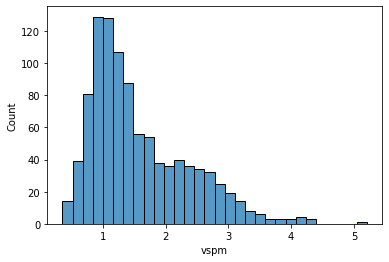

In [ ]:
# vspm
print("Asimetría -> ",games_sample['vspm'].skew())
print("Curtosis -> ",games_sample['vspm'].kurt())
print(games_sample['vspm'].describe())
sns.histplot(data=games_sample, x="vspm", bins=30)

Con el diagrama de Box-Whisker parece que tiene una ligera asimetría positiva como comentabamos, ademas de que se observan unos outliers en valores superiores a 3.3 aproximadamente.
Analizando estos outliers podemos ver que se trata de supports principalmente, este rol comple una función principalmente de utilidad en partida, lo que es bastante coherente para algo como la visión.
De todas maneras, estos outliers son simplemente algo puntual de partidas concretas, ya que estos no suman ni el 5% de las muestras totales.

muestras totales:  1001
LPL :  424
LCK :  282
LCS :  154
LEC :  141

muestras > 3.3:  28
LEC :  3
LCS :  4
LPL :  12
LCK :  9

muestras < 3.3:  973
LPL :  412
LCK :  273
LCS :  150
LEC :  138


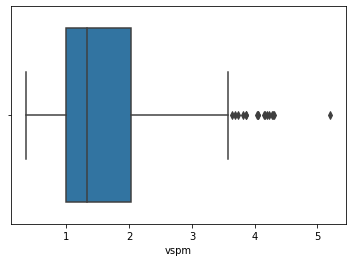

In [ ]:
sns.boxplot( x=games_sample.vspm )

print("muestras totales: ",games_sample['vspm'].count())
for x in list(pd.unique(games_sample['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x)]['vspm'].count())


print("")
print("muestras > 3.3: ",games_sample[games_sample['vspm'] > 3.3]['vspm'].count())
# print(pd.unique(games_sample[games_sample['vspm'] > 3.3]['league']))
for x in list(pd.unique(games_sample[games_sample['vspm'] > 3.3]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['vspm'] > 3.3)]['vspm'].count())

print("")
print("muestras < 3.3: ",games_sample[(games_sample['vspm'] < 3.3)]['vspm'].count())
for x in list(pd.unique(games_sample[(games_sample['vspm'] < 3.3)]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['vspm'] < 3.3)]['vspm'].count())

In [ ]:
games_sample[(games_sample['vspm'] > 3.3)]

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
36,LEC,2020,2020-09-05 14:03:49,10.16,Red,sup,Mikyx,G2 Esports,Leona,2188,0,0,4,1,7,23,5255,144.1042,0.075914,72,1.9744,14,124.0,3.4004,7201,67.5137,0.070804,39.0,1.0695
59,LCS,2020,2020-03-08 01:10:53,10.04,Blue,bot,Bang,Evil Geniuses,Senna,1850,1,6,0,9,18,3,13278,430.6378,0.245072,50,1.6216,30,128.0,4.1514,10323,203.4486,0.183648,68.0,2.2054
141,LPL,2020,2020-07-10 12:16:00,10.13,Red,jng,Wei,eStar,Graves,1985,0,2,3,1,5,15,13617,411.5970,0.242974,50,1.5113,43,122.0,3.6877,10419,184.2015,0.206345,216.0,6.5290
163,LCK,2020,2020-03-05 08:02:36,10.04,Red,jng,Clid,Gen.G,Rek'Sai,2854,1,3,4,12,28,18,12317,258.9418,0.104841,77,1.6188,38,170.0,3.5739,16099,210.2523,0.164494,257.0,5.4029
204,LCK,2020,2020-08-14 08:41:27,10.15,Blue,sup,TusiN,KT Rolster,Bard,1853,1,0,7,21,33,20,6152,199.2013,0.060657,72,2.3314,18,106.0,3.4323,8445,142.1155,0.108752,46.0,1.4895
212,LCK,2020,2020-08-20 11:42:47,10.16,Blue,sup,TusiN,KT Rolster,Bard,2673,0,0,5,9,13,22,6693,150.2357,0.080982,133,2.9854,29,191.0,4.2873,9387,82.1100,0.074088,62.0,1.3917
221,LPL,2020,2020-03-18 07:09:00,10.04,Red,bot,y4,Victory Five,Bard,2097,1,1,1,15,21,5,8212,234.9642,0.106997,69,1.9742,22,127.0,3.6338,8509,113.1903,0.097286,34.0,0.9728
241,LEC,2020,2020-02-22 16:48:53,10.03,Blue,sup,Tore,Excel Esports,Rakan,2845,1,0,3,6,10,13,6621,139.6344,0.062461,72,1.5185,43,183.0,3.8594,10842,100.4499,0.086468,47.0,0.9912
288,LPL,2020,2020-06-29 13:15:00,10.12,Red,sup,ppgod,Victory Five,Bard,1711,0,0,5,5,7,16,3840,134.6581,0.087773,63,2.2092,15,102.0,3.5769,6088,81.4261,0.089135,32.0,1.1222
323,LPL,2020,2020-07-29 12:59:00,10.14,Red,sup,Mark,LGD Gaming,Bard,1809,0,0,2,6,8,14,5077,168.3914,0.117602,72,2.3881,17,122.0,4.0464,6566,86.2355,0.089671,44.0,1.4594


## Daño infligido por minuto (variable continua)

Para empezar observamos la media y el rango en el que se encuentran la mayoria de las muestras [197.6 - 501.87] con media 366.5, bastante coherente dado que la media de daño base ronda los 60 de daño de ataque, y que hasta el minuto 10/15 solo ocurren peleas esporadicas y los jugadores se centran en dar el último golpe a los subditos para obtener oro pero no están peleando. Teniendo un autoataque cada 5 segundos de media serian unos (371.4/(60/5)) = 30.95, bastante coherente pensando que para asegurar el último golpe a un subdito deben asestar un autoataque que el daño inflingido excede por bastante su daño de ataque.

En cuanto a el coeficiente de asimetria estandarizado y la curtosis estandarizada, parece que se trata de una distribución similar a una normal, aunque con una muy ligera asimetría positiva y un poco leptocúrtica.

Asimetría ->  0.7383540518021628
Curtosis ->  0.19424475679569841
count    1001.000000
mean      360.370830
std       218.525826
min        28.027000
25%       170.179500
50%       328.503300
75%       501.193700
max      1198.813300
Name: dpm, dtype: float64


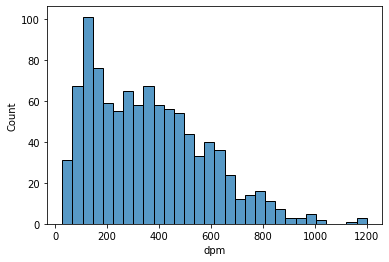

In [ ]:
# dpm
print("Asimetría -> ",games_sample['dpm'].skew())
print("Curtosis -> ",games_sample['dpm'].kurt())
print(games_sample['dpm'].describe())
sns.histplot(data=games_sample, x="dpm", bins=30)

En el diagrama de Box-Whisker podemos ver lo que parece ser una distribución similar a una normal aunque tiene una leve asimetría positiva, ademas se observan unos outliers con valores superiores a 900.

Estos valores parecen ser unos pocos correspondientes a las lineas de top, mid y bot (refiriendose este último a la posición de ad carry), tiene sentido que sean estas lineas debido a que son los roles donde se focaliza tener campeones con gran daño, suelen ser las principales fuentes de ataque del equipo. Ademas, si nos fijamos en que campeones son, vemos que son personajes que al inicio de la partida son más debiles, pero a partir del minuto 10 de partida empiezan a tener una gran cantidad de daño, más factores para entender porque encontramos estos outliers.

muestras totales:  1001
LPL :  424
LCK :  282
LCS :  154
LEC :  141

muestras > 900:  16
LPL :  7
LEC :  6
LCS :  1
LCK :  2

bot  games (>900 dpm):  10
['Varus', 'Vayne', 'Miss Fortune', 'Caitlyn', 'Kalista', 'Aphelios', 'Ezreal'] 

mid  games (>900 dpm):  5
['Kassadin', 'Rumble', 'Corki'] 

top  games (>900 dpm):  1
['Kennen'] 


muestras < 900:  985
LPL :  417
LCK :  280
LCS :  153
LEC :  135



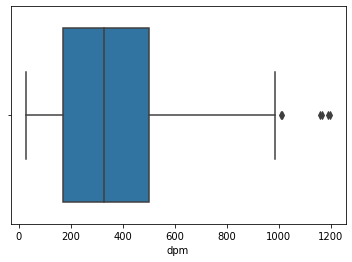

In [ ]:
sns.boxplot( x=games_sample.dpm )

print("muestras totales: ",games_sample['dpm'].count())
for x in list(pd.unique(games_sample['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x)]['dpm'].count())

print("")
print("muestras > 900: ",games_sample[games_sample['dpm'] > 900]['dpm'].count())
# print(pd.unique(games_sample[games_sample['dpm'] > 900]['league']))
for x in list(pd.unique(games_sample[games_sample['dpm'] > 900]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['dpm'] > 900)]['dpm'].count())
print("")

dpm_outliers = games_sample[(games_sample['dpm'] > 900)]
dpm_outliers_roles = list(pd.unique(dpm_outliers['position']))
for role in dpm_outliers_roles:
  print(role, " games (>900 dpm): ", (dpm_outliers[dpm_outliers['position'] == role])['position'].count())
  print(list(pd.unique(dpm_outliers[dpm_outliers['position'] == role]['champion'])),"\n")

print("")
print("muestras < 900: ",games_sample[(games_sample['dpm'] < 900)]['dpm'].count())
for x in list(pd.unique(games_sample[(games_sample['dpm'] < 900)]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['dpm'] < 900)]['dpm'].count())
print("")


## Total de Subditos eliminados (variable discreta)


Asimetría ->  -0.09921599367157831
Curtosis ->  -0.8476600953914497
count    1001.000000
mean      202.848152
std       116.671303
min         4.000000
25%       115.000000
50%       219.000000
75%       283.000000
max       556.000000
Name: total cs, dtype: float64


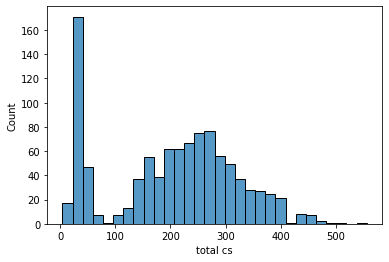

In [ ]:
# total cs
print("Asimetría -> ",games_sample['total cs'].skew())
print("Curtosis -> ",games_sample['total cs'].kurt())
print(games_sample['total cs'].describe())
sns.histplot(data=games_sample, x="total cs", bins=30)

muestras totales:  1001
LPL :  424
LCK :  282
LCS :  154
LEC :  141

muestras > 500:  2
LCK :  1
LCS :  1

muestras < 500:  999
LPL :  424
LCK :  281
LCS :  153
LEC :  141


,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm
23,LCK,2020,2020-07-26 08:34:44,10.14,Blue,bot,HyBriD,SeolHaeOne Prince,Kai'Sa,2729,0,6,2,7,16,21,29258,643.2686,0.263959,16,0.3518,16,45.0,0.9894,21231,338.3217,0.323485,501.0,11.0150
248,LCS,2020,2020-01-26 20:35:10,10.01,Red,bot,Altec,Immortals,Ezreal,3680,1,4,0,2,9,9,49118,800.8370,0.387708,26,0.4239,24,69.0,1.1250,24942,279.7663,0.297675,556.0,9.0652


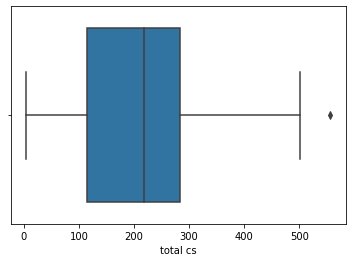

In [ ]:
sns.boxplot( x=games_sample["total cs"] )

print("muestras totales: ",games_sample['total cs'].count())
for x in list(pd.unique(games_sample['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x)]['total cs'].count())

print("")
print("muestras > 500: ",games_sample[games_sample['total cs'] > 500]['total cs'].count())
# print(pd.unique(games_sample[games_sample['total cs'] > 500]['league']))
for x in list(pd.unique(games_sample[games_sample['total cs'] > 500]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['total cs'] > 500)]['total cs'].count())

print("")
print("muestras < 500: ",games_sample[(games_sample['total cs'] < 500)]['total cs'].count())
for x in list(pd.unique(games_sample[(games_sample['total cs'] < 500)]['league'])):
  print(x, ": ", games_sample[(games_sample['league'] == x) & (games_sample['total cs'] < 500)]['total cs'].count())

games_sample[(games_sample['total cs'] > 500)]

## Variables categóricas

Para las variables categóricas hemos elegido primero la de ligas, en esta observamos que la LPL (liga china) es la que más partidas tiene, seguida de la LCK (liga coreana). Este repunte de la LPL se debe a que esta liga cuenta con 17 equipos que juegan todas las semanas con un formato de 6 partidas por jornada, la LCK cuenta con el mismo tipo de formato de 6 partidas semanales, pero solo cuenta con 10 equipos (razón por la que tiene menos partidas). Por último la LEC (liga Europea) y la LCS (liga Norteamericana) cuentan con 10 equipos y 2 partidos semanales.

Por lo cual, debido a el numero de partidos que tiene cada liga semanalmente y el numero de equipos, es coherente el balance de muestras por liga.

LPL    0.423576
LCK    0.281718
LCS    0.153846
LEC    0.140859
Name: league, dtype: float64


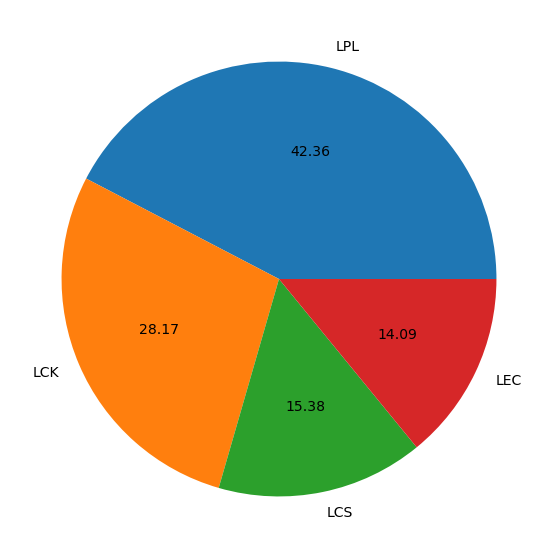

In [ ]:
count_data = games_sample.league.value_counts()
plt.figure(figsize=(10, 10))
fig = plt.pie( count_data, labels = count_data.index, autopct="%.2f", textprops={"fontsize":14} )
print(games_sample.league.value_counts(normalize=True))

La segunda variable categórica que vamos a analizar es la posición en partida, vemos que están bastante repartidas las muestras, y esto es algo normal dado que en una partida juegan 2 personas de cada posición. La ligera diferencia que se encuentra más notoriamente entre bot y las demas posiciones se debe a que hay datos que se han perdido al limpiar y reducir los datos.

sup    0.234765
bot    0.195804
mid    0.193806
top    0.190809
jng    0.184815
Name: position, dtype: float64


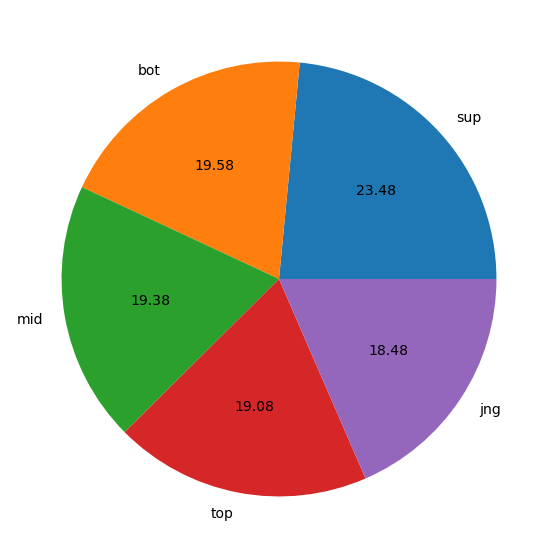

In [ ]:
count_data = games_sample.position.value_counts()
plt.figure(figsize=(10, 10))
fig = plt.pie( count_data, labels = count_data.index, autopct="%.2f", textprops={"fontsize":14} )
print(games_sample.position.value_counts(normalize=True))

# Normalidad de los datos e inferencia

## Duración de partidas

Vamos a ver si la variable de duración de cada partida sigue una distribución normal o parecida a una normal:

In [ ]:
sample = games_sample.sample(n=100)
print( stats.skewtest( sample['gamelength'] ) , "\n -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)\n" )
print( stats.kurtosistest( sample['gamelength'] ) , "\n -> H0:  El coeficiente de curtosis (CC) de la población sigue una curtosis propia de una población normal (CC=0)\n")
print( stats.kstest( (sample['gamelength']-sample['gamelength'].mean())/sample['gamelength'].std(), 'norm'  ) , "\n -> H0:  La función de distribución acumulada se comporta como la función de distribución acumulada de una distribución normal.\n")
print( stats.shapiro( sample['gamelength'] ) , "\n -> H1: La variable aleatoria estudiada no procede de una población normal\n")

SkewtestResult(statistic=1.7189950389605877, pvalue=0.08561527526920458) 
 -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)

KurtosistestResult(statistic=-0.08793056532513183, pvalue=0.9299318630698733) 
 -> H0:  El coeficiente de curtosis (CC) de la población sigue una curtosis propia de una población normal (CC=0)

KstestResult(statistic=0.09163051026048552, pvalue=0.3511097091966066) 
 -> H0:  La función de distribución acumulada se comporta como la función de distribución acumulada de una distribución normal.

(0.9824097752571106, 0.20388764142990112) 
 -> H1: La variable aleatoria estudiada no procede de una población normal



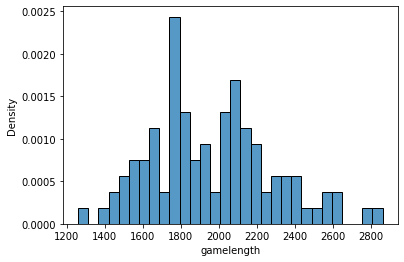

In [ ]:
sns.histplot(x=sample.gamelength, stat="density", common_norm=False, bins=30)

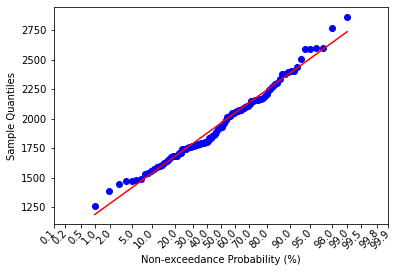

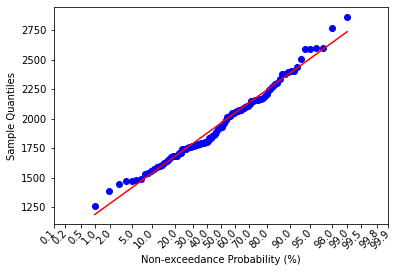

In [ ]:
# papel probabilistico
plot = sm.ProbPlot( sample['gamelength'], dist="norm" )
plot.probplot(line="r")

Aunque no parece que se trate de una distribución normal, se aproxima a la normal, mientras que los test de normalidad nos dicen que no se trata de una normal, observando el histograma y el papel probabilistico, deducimos que se trata de una distribución aproximadamente normal aunque tiene una asimetria por la derecha.

## Puntuación de visión por minuto

Ahora vamos a analizar la normalidad en la distribución de vspm (puntuación de visión por minuto):

In [ ]:
print( stats.skewtest( sample['vspm'] ) , "\n -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)\n" )
print( stats.kurtosistest( sample['vspm'] ) , "\n -> H1:  El coeficiente de curtosis (CC) de la población tiene una curtosis diferente a la de una población normal (CC!=0)\n")
print( stats.kstest( (sample['vspm']-sample['vspm'].mean())/sample['vspm'].std(), 'norm'  ) , "\n -> H1: La función de distribución acumulada difiere de la función de distribución acumulada de una distribución normal.\n")
print( stats.shapiro( sample['vspm'] ) , "\n -> H1: La variable aleatoria estudiada no procede de una población normal\n")

SkewtestResult(statistic=3.509103402728969, pvalue=0.00044962006442107613) 
 -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)

KurtosistestResult(statistic=0.2767546673228197, pvalue=0.7819684921871456) 
 -> H1:  El coeficiente de curtosis (CC) de la población tiene una curtosis diferente a la de una población normal (CC!=0)

KstestResult(statistic=0.14972158455686424, pvalue=0.020179616388326962) 
 -> H1: La función de distribución acumulada difiere de la función de distribución acumulada de una distribución normal.

(0.9102839827537537, 4.451768290891778e-06) 
 -> H1: La variable aleatoria estudiada no procede de una población normal



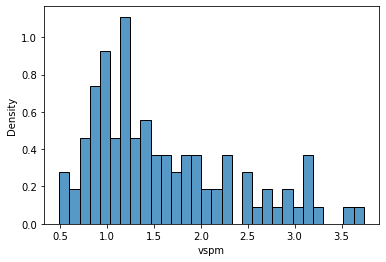

In [ ]:
sns.histplot(x=sample.vspm, stat="density", common_norm=False, bins=30)

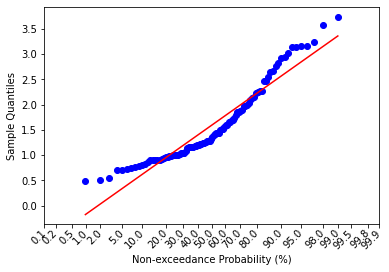

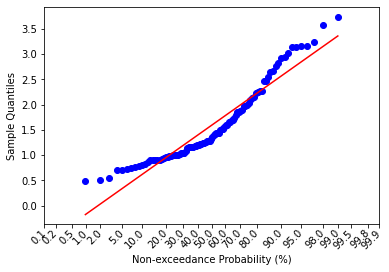

In [ ]:
# papel probabilistico
plot = sm.ProbPlot( sample['vspm'], dist="norm" )
plot.probplot(line="r")

Después de observar los test de normalidad y el papel probabilistico, concluimos que la distribución no sigue una normal, por lo que vamos a tratar de aproximarla haciendo uso de una transformación:

In [ ]:
log_sample = sample.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
square_sample = sample.apply(lambda x: np.square(x) if np.issubdtype(x.dtype, np.number) else x)
reciproco_sample = sample.apply(lambda x: (1/x) if np.issubdtype(x.dtype, np.number) else x)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Transformación Reciproca')

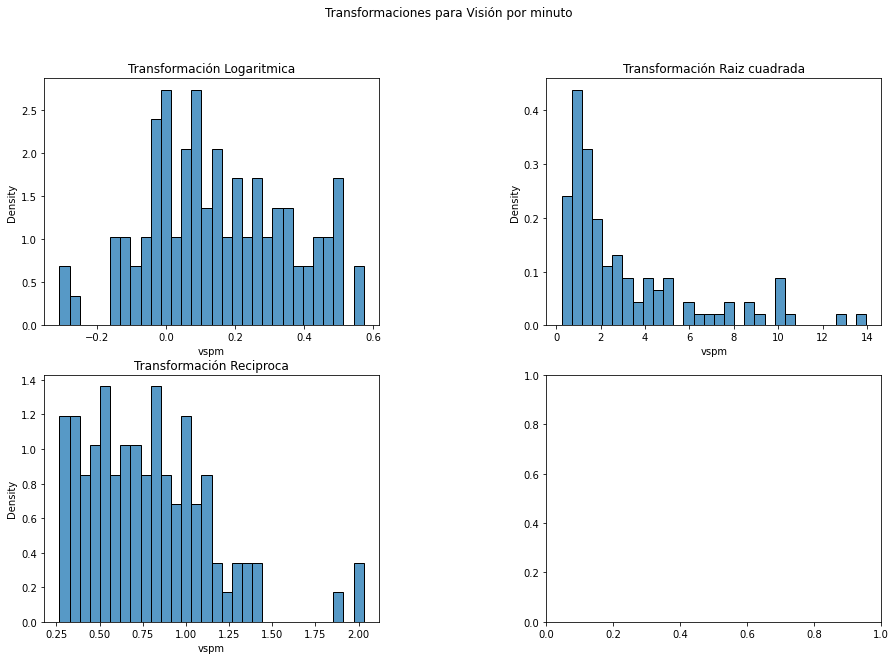

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
fig.suptitle("Transformaciones para Visión por minuto")

sns.histplot(x=log_sample.vspm, stat="density", common_norm=False, bins=30,ax=axes[0,0])
axes[0,0].set_title("Transformación Logaritmica")
sns.histplot(x=square_sample.vspm, stat="density", common_norm=False, bins=30,ax=axes[0,1])
axes[0,1].set_title("Transformación Raiz cuadrada")
sns.histplot(x=reciproco_sample.vspm, stat="density", common_norm=False, bins=30,ax=axes[1,0])
axes[1,0].set_title("Transformación Reciproca")


Después de hacer las transformaciones y analizar los histogramas, vemos que la transformación logaritmica es la única que parece acercarse más a una normal que la distribución original, vamos a ver si realmente se aproxima a una normal por el papel probabilístico:

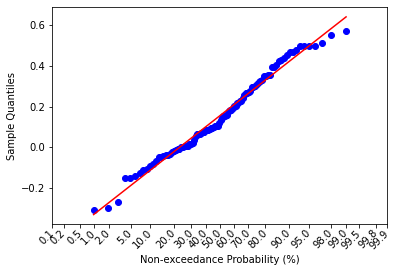

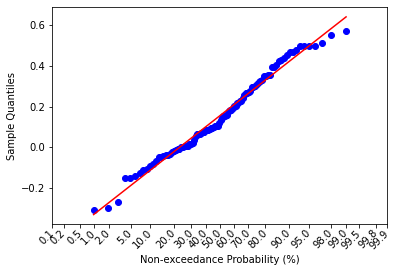

In [ ]:
# papel probabilistico
plot = sm.ProbPlot( log_sample['vspm'], dist="norm" )
plot.probplot(line="r")

Podemos concluir que despues de realizar una transformación logaritmica, nuestra distribución si que se aproxima bastante a una normal.

## Daño inflingido por minuto

Por último vamos a analizar la normalidad de la distribución de daño inflingido por minuto (dpm):

In [ ]:
print( stats.skewtest( sample['dpm'] ) , "\n -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)\n" )
print( stats.kurtosistest( sample['dpm'] ) , "\n -> H0:  El coeficiente de curtosis (CC) de la población sigue una curtosis propia de una población normal (CC=0)\n")
print( stats.kstest( (sample['dpm']-sample['dpm'].mean())/sample['dpm'].std(), 'norm'  ) , "\n -> H0:  La función de distribución acumulada se comporta como la función de distribución acumulada de una distribución normal.\n")
print( stats.shapiro( sample['dpm'] ) , "\n -> H1: La variable aleatoria estudiada no procede de una población normal\n")

SkewtestResult(statistic=2.430440787119344, pvalue=0.015080469977718822) 
 -> H1:  El coeficiente de asimetría (CA) de la población sigue una asimetría diferente de una población normal (CA != 0)

KurtosistestResult(statistic=-1.007515204813949, pvalue=0.31368725472297887) 
 -> H0:  El coeficiente de curtosis (CC) de la población sigue una curtosis propia de una población normal (CC=0)

KstestResult(statistic=0.10463336463761091, pvalue=0.20869998043891305) 
 -> H0:  La función de distribución acumulada se comporta como la función de distribución acumulada de una distribución normal.

(0.9441318511962891, 0.0003475842531770468) 
 -> H1: La variable aleatoria estudiada no procede de una población normal



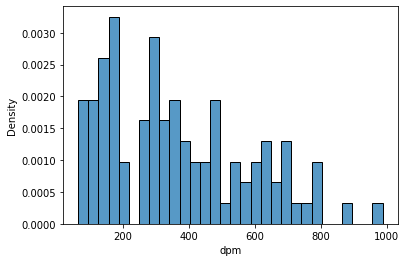

In [ ]:
sns.histplot(x=sample.dpm, stat="density", common_norm=False, bins=30)

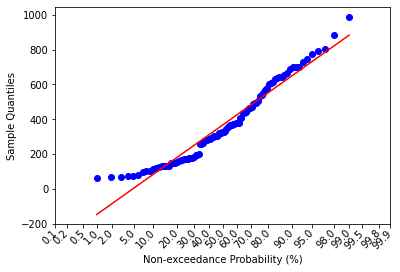

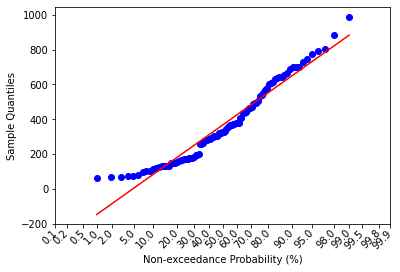

In [ ]:
# papel probabilistico
plot = sm.ProbPlot( sample['dpm'], dist="norm" )
plot.probplot(line="r")

Después de observar el histograma, el papel probabilístico y los test de normalidad, asumiendo el hecho que hemos visto en el analisis descriptivo, se trata de una distribución aproximadamente normal.

## Construir Intervalos de Confianza de la media (Daño inflingido por minuto)



Intervalo del 95%: (  324.92683931201844 411.6668126879816 )
Intervalo del 90%: (  332.0048558716062 404.5887961283938 )
Intervalo del 70%: (  345.5237172809627 391.0699347190373 )



([<matplotlib.axis.YTick at 0x7f52d19b1a20>,
 [Text(0, 0, '95%'), Text(0, 0, '90%'), Text(0, 0, '70%')])

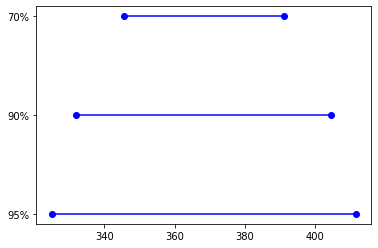

In [ ]:
x = sample.dpm.mean()
n = sample.shape[0]
s = sample.dpm.std()

# intervalo del 95%
lower_bound_95 = 0
upper_bound_95 = 0
t_95 = stats.t.ppf(0.975, n-1 )
lower_bound_95 = x - t_95 * s/math.sqrt(n)
upper_bound_95 = x + t_95 * s/math.sqrt(n)
print("Intervalo del 95%: ( " , lower_bound_95, upper_bound_95 , ")")

# intervalo del 90%
lower_bound_90 = 0
upper_bound_90 = 0
t_90 = stats.t.ppf(0.95, n-1 )
lower_bound_90 = x - t_90 * s/math.sqrt(n)
upper_bound_90 = x + t_90 * s/math.sqrt(n)
print("Intervalo del 90%: ( " , lower_bound_90, upper_bound_90 , ")")

# intervalo del 70%
lower_bound_70 = 0
upper_bound_70 = 0
t_70 = stats.t.ppf(0.85, n-1 )
lower_bound_70 = x - t_70 * s/math.sqrt(n)
upper_bound_70 = x + t_70 * s/math.sqrt(n)
print("Intervalo del 70%: ( " , lower_bound_70, upper_bound_70 , ")")
print("")

data_dict = {}
data_dict['category'] = ['95%','90%','70%']
data_dict['lower'] = [lower_bound_95,lower_bound_90,lower_bound_70]
data_dict['upper'] = [upper_bound_95,upper_bound_90,upper_bound_70]
intervalos = pd.DataFrame(data_dict)

plots = {}
count = 0
for lower,upper,y in zip(intervalos['lower'],intervalos['upper'],range(len(intervalos))):
    plots[count] = plt.plot((lower,upper),(y,y),'ro-',color='blue')
    count += 1
plt.yticks(range(len(intervalos)),list(intervalos['category']))

Después de analizar el intervalo de confianza para un nivel de significancia de 95%, 90% y 70%. Podemos ver como en un nivel del 70%, como tiene que encontrarse la media el 70% de las veces en este intervalo, se trata de un intervalo más estrecho que el de 90% o 95%.

## Construir Intervalos de Confianza de la varianza (Daño inflingido por minuto)

Vamos a realizar un analisis de los intervalos de confianza de la varianza haciendo uso de chi-cuadrado:


Intervalo de varianza del 95%: (  168.49846043690167 294.96440505388534 )
Intervalo de varianza del 90%: (  200.18739057374518 242.6397473719607 )


([<matplotlib.axis.YTick at 0x7f52d212a198>,
 [Text(0, 0, '95%'), Text(0, 0, '90%')])

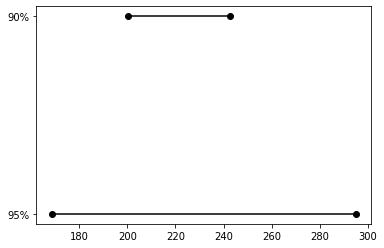

In [ ]:
x = sample.dpm.mean()
n = sample.shape[0]
s = sample.dpm.std()

# intervalo del 95%
lower_bound_95 = 0
upper_bound_95 = 0
chi1_95 = stats.chi2.ppf(1-0.05/2, n - 1 )
chi2_95 = stats.chi2.ppf(0.05/2, n - 1 )
lower_bound_95 = (n-1)*s/chi1_95
upper_bound_95 = (n-1)*s/chi2_95
print("Intervalo de varianza del 95%: ( " , lower_bound_95, upper_bound_95 , ")")

# intervalo del 90%
lower_bound_90 = 0
upper_bound_90 = 0
chi1_90 = stats.chi2.ppf(1-0.5/2, n - 1 )
chi2_90 = stats.chi2.ppf(0.5/2, n - 1 )
lower_bound_90 = (n-1)*s/chi1_90
upper_bound_90 = (n-1)*s/chi2_90
print("Intervalo de varianza del 90%: ( " , lower_bound_90, upper_bound_90 , ")")

data_dict = {}
data_dict['category'] = ['95%','90%']
data_dict['lower'] = [lower_bound_95,lower_bound_90]
data_dict['upper'] = [upper_bound_95,upper_bound_90]
intervalos = pd.DataFrame(data_dict)

plots = {}
count = 0
for lower,upper,y in zip(intervalos['lower'],intervalos['upper'],range(len(intervalos))):
    plots[count] = plt.plot((lower,upper),(y,y),'ro-',color='black')
    count += 1
plt.yticks(range(len(intervalos)),list(intervalos['category']))


En el intervalo de confianza de varianza, podemos ver como el intervalo del 90%, dado que tiene menos precisión que el del 95%, se trata de un intervalo más pequeño.

# ANOVA

## ANOVA con un factor

Ahora vamos a realizar un analisis de varianza para ver las diferencias en la duración de las partidas entre cada una de las ligas:
 - Primero vamos a crear columnas binarias para cada una de las ligas y vamos a ver como se distribuyen estas (

In [ ]:
ligas = list(pd.unique(games_sample['league']))
for liga in ligas:
  r = games_sample.league.apply(lambda x: liga in x)
  games_sample=games_sample.assign( **{liga: r} )
games_sample.head(5)

,league,year,date,patch,side,position,player,team,champion,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,damagetochampions,dpm,damageshare,wardsplaced,wpm,wardskilled,visionscore,vspm,totalgold,earned gpm,earnedgoldshare,total cs,cspm,LPL,LCK,LCS,LEC
0,LPL,2020,2020-06-07 12:59:00,10.11,Red,mid,FoFo,Bilibili Gaming,Twisted Fate,1809,0,0,4,6,6,15,12864,426.6667,0.228669,16,0.5307,2,16.0,0.5307,9714,190.6468,0.200811,202.0,6.6998,True,False,False,False
1,LCK,2020,2020-07-01 08:47:25,10.12,Blue,sup,BeryL,DAMWON Gaming,Thresh,2952,1,3,2,6,12,8,2951,59.9797,0.032232,94,1.9106,26,160.0,3.2520,11104,97.6829,0.087776,47.0,0.9553,False,True,False,False
2,LPL,2020,2020-01-14 11:21:00,10.01,Red,sup,LvMao,JD Gaming,Nautilus,1666,1,0,2,11,16,5,3783,136.2425,0.075920,42,1.5126,13,66.0,2.3770,6444,99.7599,0.079193,33.0,1.1885,True,False,False,False
3,LCK,2020,2020-06-19 08:49:01,10.11,Blue,mid,Dove,SANDBOX Gaming,Azir,1449,0,3,7,0,7,24,12578,520.8282,0.300959,11,0.4555,3,22.0,0.9110,9966,278.8406,0.305636,231.0,9.5652,False,True,False,False
4,LCK,2020,2020-06-19 08:49:01,10.11,Blue,sup,GorillA,SANDBOX Gaming,Thresh,1449,0,0,6,6,7,24,2218,91.8427,0.053071,34,1.4079,4,48.0,1.9876,5160,79.8344,0.087520,24.0,0.9938,False,True,False,False


Text(0.5, 1.0, 'LCS')

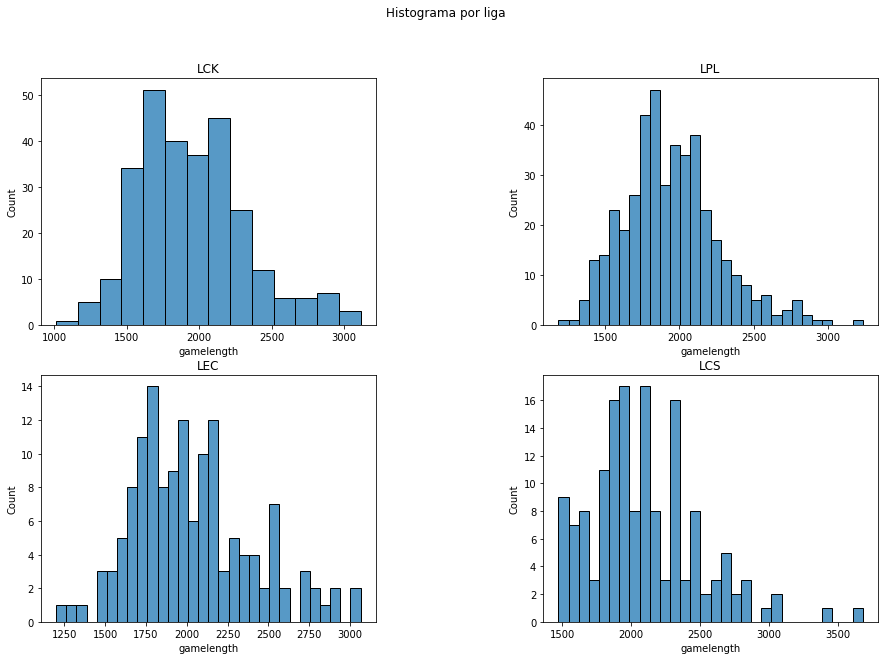

In [ ]:
fig_leagues, axes_leagues = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
fig_leagues.suptitle("Histograma por liga")

lck_gamelength = games_sample[games_sample['LCK']].gamelength
lpl_gamelength = games_sample[games_sample['LPL']].gamelength
lec_gamelength = games_sample[games_sample['LEC']].gamelength
lcs_gamelength = games_sample[games_sample['LCS']].gamelength

sns.histplot(x=lck_gamelength, ax=axes_leagues[0,0])
axes_leagues[0,0].set_title("LCK")
sns.histplot(x=lpl_gamelength, bins=30,ax=axes_leagues[0,1])
axes_leagues[0,1].set_title("LPL")
sns.histplot(x=lec_gamelength, bins=30,ax=axes_leagues[1,0])
axes_leagues[1,0].set_title("LEC")
sns.histplot(x=lcs_gamelength, bins=30,ax=axes_leagues[1,1])
axes_leagues[1,1].set_title("LCS")

Text(0.5, 1.0, 'LCS')

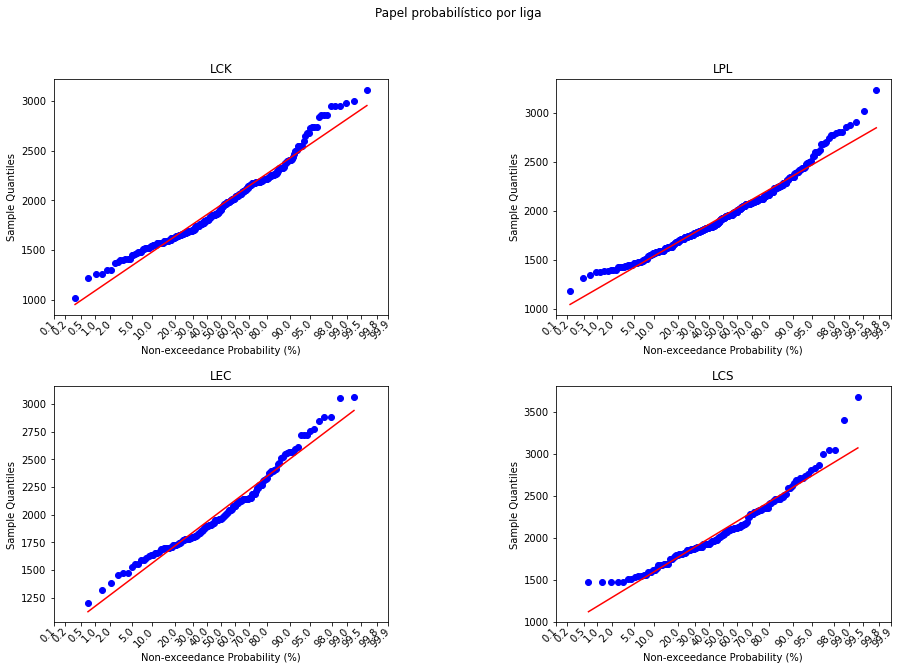

In [ ]:
fig_leagues, axes_leagues = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.3)
fig_leagues.suptitle("Papel probabilístico por liga")

lck_gamelength = games_sample[games_sample['LCK']].gamelength
lpl_gamelength = games_sample[games_sample['LPL']].gamelength
lec_gamelength = games_sample[games_sample['LEC']].gamelength
lcs_gamelength = games_sample[games_sample['LCS']].gamelength

sm.ProbPlot(lck_gamelength,dist="norm").probplot(line="r",ax=axes_leagues[0,0])
axes_leagues[0,0].set_title("LCK")
sm.ProbPlot(lpl_gamelength,dist="norm").probplot(line="r",ax=axes_leagues[0,1])
axes_leagues[0,1].set_title("LPL")
sm.ProbPlot(lec_gamelength,dist="norm").probplot(line="r",ax=axes_leagues[1,0])
axes_leagues[1,0].set_title("LEC")
sm.ProbPlot(lcs_gamelength,dist="norm").probplot(line="r",ax=axes_leagues[1,1])
axes_leagues[1,1].set_title("LCS")

Como podemos ver que las distribuciones para cada una de las variables siguen lo que parece ser una normal.

Vamos a comprobar que se cumple la hipótesis de homocedasticidad y posteriormente haremos una comparación de las medias entre cada una de las ligas haciendo uso de ANOVA (ANalysis Of VAriance).

Usaremos la prueba de **Levene** ya que es una prueba relativamente robusta ante desviaciones de la normal. Este contraste de hipotesis establece las siguientes hipótesis:

$H_0: \sigma_1 = \sigma_2 = \dots = \sigma_k$

$H_1: \exists i,j , \; \sigma_i \neq \sigma_k$

In [ ]:
lck_gamelength = games_sample[games_sample['LCK']].gamelength
lpl_gamelength = games_sample[games_sample['LPL']].gamelength
lec_gamelength = games_sample[games_sample['LEC']].gamelength
lcs_gamelength = games_sample[games_sample['LCS']].gamelength

stats.levene(lck_gamelength,lpl_gamelength,lec_gamelength,lcs_gamelength)
print("[", lck_gamelength.std(), " - ", lpl_gamelength.std(), " - ", lec_gamelength.std(), " - ", lcs_gamelength.std(),"]")
print("La prueba de Levene nos dice que parece que las varianzas son distintas")

[ 370.9200040141474  -  319.0693705272607  -  366.12362269075  -  393.4203950057991 ]
La prueba de Levene nos dice que parece que las varianzas son distintas


Aunque la normalidad de las poblaciones no es demasiado precisa y que la prueba de levene nos dice que parece que al menos hay 2 varianzas distintas (aunque vemos que las diferencias son leves si nos fijamos que 3 de las varianzas son bastante similares), pero ANOVA es relativamente robusto ante estas pequeñas variaciones por lo que no hay problema.

Ahora vamos a realizar un **ANOVA** con la liga como factor para encontrar las diferencias significativas en la media de las diferentes poblaciones, las hipotesis que establece ANOVA son:

$H_0: \mu_1 = \mu_2 = \dots = \mu_k$ (provienen de la misma población)

$H_1: \exists i,j \;\; \mu_i\neq \mu_j$ (provienen de poblaciones diferentes)



In [ ]:
lm = ols( 'gamelength ~ C(league)', data=games_sample ).fit(cov_type="HC3")
anova_table = sm.stats.anova_lm(lm, typ=1,  robust="HC3")
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(league),3.0,3.089022e+06,1.029674e+06,8.267452,0.00002
Residual,997.0,1.241719e+08,1.245455e+05,NaN,NaN


El análisis de ANOVA nos devuelve un p-value que indica que para el nivel de significancia de 0.05 se acepta la hipotesis alternativa, por lo que consideramos que las medias son diferentes.

Después de realizar el ANOVA y que nos diga que al menos una media poblacional es diferente, vamos a analizar cual es, para esto usaremos los intervalos de Tukey:

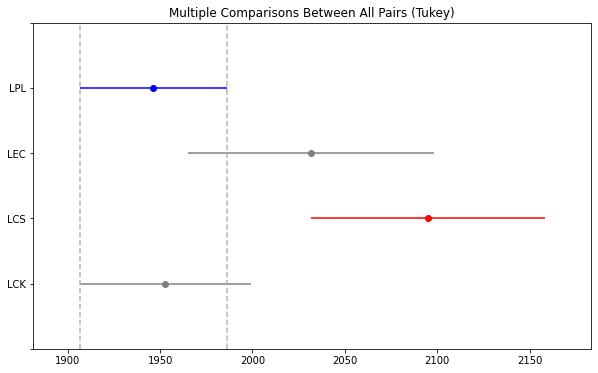

In [ ]:
tukey = sm.stats.multicomp.pairwise_tukeyhsd(games_sample.gamelength, games_sample.league, alpha=0.01).plot_simultaneous(comparison_name="LPL")

In [ ]:
print("LCK -> ",len(lck_gamelength))
print("LPL -> ", len(lpl_gamelength))
print("LEC -> ", len(lec_gamelength))
print("LCS -> ", len(lcs_gamelength))

LCK ->  282
LPL ->  424
LEC ->  141
LCS ->  154


In [ ]:
# levene para comprobar el ANOVA
lck_gamelength = games_sample[games_sample['LCK']].gamelength
lpl_gamelength = games_sample[games_sample['LPL']].gamelength
lec_gamelength = games_sample[games_sample['LEC']].gamelength
lcs_gamelength = games_sample[games_sample['LCS']].gamelength

stats.levene(lck_gamelength,lpl_gamelength,lec_gamelength,lcs_gamelength)
print("[", lck_gamelength.std(), " - ", lpl_gamelength.std(), " - ", lec_gamelength.std(), " - ", lcs_gamelength.std(),"]")
print("La prueba de Levene nos dice que parece que las varianzas son distintas")

[ 370.9200040141474  -  319.0693705272607  -  366.12362269075  -  393.4203950057991 ]
La prueba de Levene nos dice que parece que las varianzas son distintas


Según la prueba de levene tambien dice que se trata de varianzas diferentes, pero si nos fijamos en el tamaño de cada muestra podemos ver que la LPL (liga china) tiene un gran número de muestras en comparación con las demás poblaciones, si nos fijamos en los intervalos de tukey y en las diferencias que hay al analizar las varianzas, podemos concluir que el alto número de muestras con las que cuenta la LPL cause que se generen unas diferencias tan exageradas.

## ANOVA con múltiples factores

Para el ANOVA con múltiples factores vamos a analizar el efecto de la posición de los jugadores (top, jungla, mid, adc y support) y de la liga en la que se juega (LCK, LPL, LEC, LCS) en el daño inflingido por minuto.

In [ ]:
lm = ols( 'dpm ~ C(league) + C(position) + C(league)*C(position)', data=games_sample ).fit(cov_type="HC3")
anova_table = sm.stats.anova_lm(lm, typ=2, robust="HC3")
anova_table

,sum_sq,df,F,PR(>F)
C(league),5.357507e+04,3.0,0.784126,5.028669e-01
C(position),3.609560e+07,4.0,396.221736,4.628890e-203
C(league):C(position),6.210768e+05,12.0,2.272522,7.638721e-03
Residual,2.234215e+07,981.0,NaN,NaN


Tras analizar los resultados, podemos ver que si existe una significancia en la interacción si consideramos un nivel de significancia de $\alpha=0.05$, ademas podemos ver que la variable de ligas si es significativa igual de las posiciones.

Como hemos obtenido que las interacciones SI son significativas, vamos a analizar los gráficos de interacción:

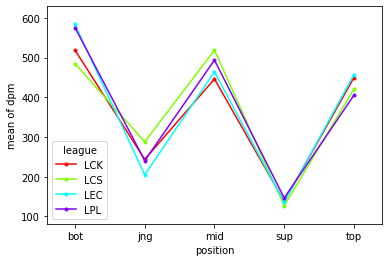

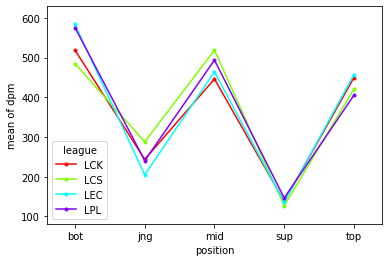

In [ ]:
sm.graphics.interaction_plot(x=games_sample.position, trace=games_sample.league, response=games_sample.dpm)

Con los gráficos de interacciones podemos observar ciertas cosas:
  - La interacción como se puede ver en las lineas es de una fuerte significancia ya que las lineas se cruzan.
  - Existe una gran similitud entre la LCK y la LPL, se denota una fuerte relación entre estas en todos los roles, esto tiene sentido ya que ambas son ligas asiaticas que destacan por un estilo de juego similar.
  - Los roles de bot, mid y top son notablemente más altos que los demas, esto tiene sentido ya que son los roles que cuentan con los objetos más poderosos de la partida.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

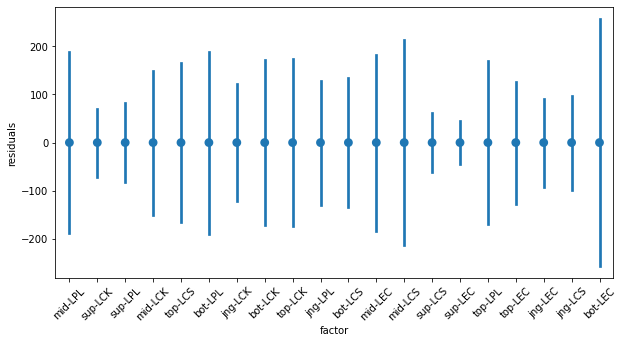

In [ ]:
residuals = lm.resid
plt.figure( figsize=(10, 5) )
sns.pointplot( data=games_sample.assign(residuals=residuals, factor=games_sample.apply(lambda row: str(row.position)+"-"+str(row.league), axis=1)), x="factor", y="residuals", ci="sd", join=False )
plt.xticks(rotation=45)

<Figure size 432x288 with 0 Axes>

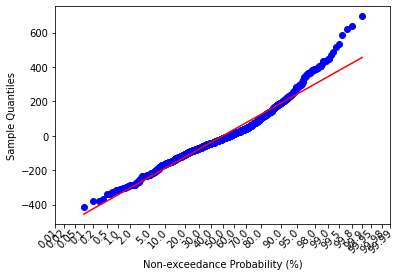

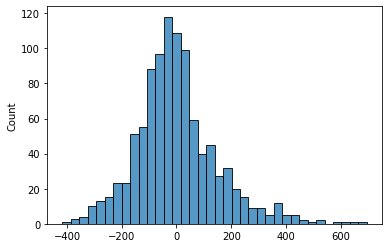

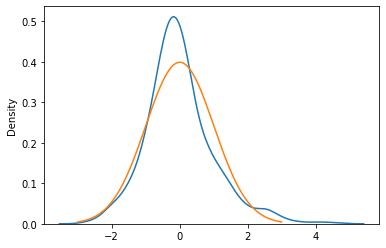

In [ ]:
plot = sm.ProbPlot(residuals, dist="norm")
plt.figure()
plot.probplot(line="r")
plt.figure()
sns.histplot(residuals)
plt.figure()
axes = sns.kdeplot( (residuals - residuals.mean() )/(residuals.std()), common_norm=False  )
sns.lineplot( y=[ stats.norm.pdf(x) for x in np.arange(-3, 3, 0.01) ], x= [x for x in np.arange(-3, 3, 0.01)] )

Después de analizar los residuos podemos ver que estos tienen un comportamiendo aproximadamente normal y las subpoblaciones son lo suficientemente grandes como para fiarnos, por lo que podemos asegurarnos del ANOVA realizado.

# Regresión lineal

## Regresión Lineal Simple

Vamos a realizar una regresión lineal con variable predictora X=duración de partidas y una variable dependiente (a predecir) Y=daño por minuto.

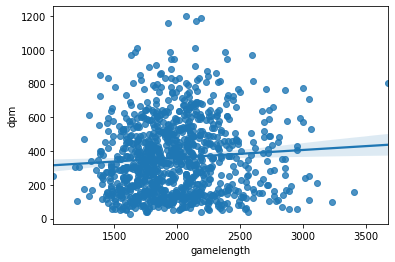

In [ ]:
# X = games_sample[ (games_sample['position'] == 'top') & (games_sample['league'] == 'LCK')].dpm
# Y = games_sample[ (games_sample['position'] == 'top') & (games_sample['league'] == 'LCK')].gamelength
# sample_regression = games_sample.sample(n=100)
X = games_sample.gamelength
Y = games_sample.dpm
sns.regplot( x=X, y=Y )

In [ ]:
simple_r = stats.pearsonr(X,Y)
print("Coeficiente de Correlación: ", simple_r[0])
print("p-value: ", simple_r[1])

Coeficiente de Correlación:  0.07437762804524178
p-value:  0.01859645430688625


Obtenemos un coeficiente de correlación de 0.074 con un p-value de 0.018.

Observando el gráfico de dispersión y el coeficiente de correlación, estos muestran que existe relación lineal, con una intensidad de (r = 0.074) y significancia (p-value = 0.018). Vamos a generar un modelo de regresión lineal simple, aunque observando el gráfico de dispersión no parece dar buenas señales.

In [ ]:
lm = ols('Y ~ X', data=pd.DataFrame().assign(X=X, Y=Y) )
fitted_model = lm.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.557
Date:                Thu, 21 Jan 2021   Prob (F-statistic):             0.0186
Time:                        18:03:24   Log-Likelihood:                -6809.4
No. Observations:                1001   AIC:                         1.362e+04
Df Residuals:                     999   BIC:                         1.363e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    270.0202     38.941      6.934      0.0

Depués de realizar el análisis de regresión, podemos ver, como anteriormente que existe relación lineal entre las variables analizadas, aunque esto tambien puede deberse a que estamos trabajando con 1000 muestras y cabe la posibilidad de que esté introduciendo ruido en el analisis. 

Tambien se observa una $r^2$ de 0.005, lo que nos dice que el 0.5% de los datos de daño por minuto son explicados por la duración de las partidas, esto nos hace entender que se trata de un modelo con una capacidad predictiva casi nula.

La ecuación resultante es:
$y = 106.18 + 0.11x $

Ahora vamos a analizar los residuos para contrastar las hipotesis del analisis de regresión:

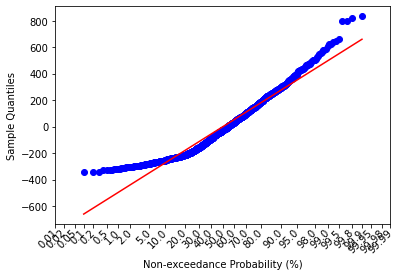

In [ ]:
# normalidad de los residuos
plot = sm.ProbPlot(data=fitted_model.resid).probplot(line="r")

Text(0, 0.5, 'Residual')

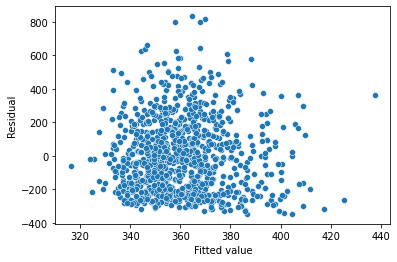

In [ ]:
# analisis del error (comprobar homocedasticidad)
f=sns.scatterplot(x=fitted_model.predict(), y=fitted_model.resid)
f.set_xlabel("Fitted value")
f.set_ylabel("Residual")

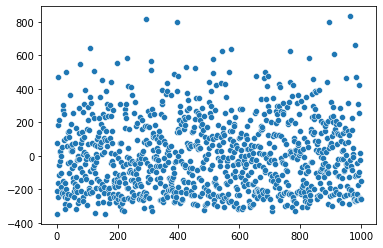

In [ ]:
f=sns.scatterplot(x=[i for i in range(len(X))], y=fitted_model.resid)

Después de observar los residuos, podemos ver que:
 - Parece que los residuos no siguen bien una normal ya que parece que se están acercando a una ecuación cuadratica o a otra forma diferente de una normal.
 - Observamos tambien que al observar la predicción realizada para los datos de la muestra con respecto al residuo (error cometido en la prediccón) se puede ver que los residuos tienen un comportamiento heterocedastico.
 - Parece que tambien hay cierta independencia al observar los errores.

Después de observar los residuos, podemos contrastar, como esperabamos, que el modelo nos ofrece unas predicciones bastante pobres.

## Regresión Múltiple

Ahora vamos a realizar un analisis de regresión similar pero añadiendo otra variable predictora de manera que quedará:
 - X1 = duración de partidas (predictora 1)
 - X2 = visión por minuto (predictora 2)
 - Y = daño por minuto (dependiente)


In [ ]:
X1 = games_sample.gamelength
X2 = games_sample.vspm
Y = games_sample.dpm

# analisis de regresión
lm = ols('Y ~ X1 + X2', data=pd.DataFrame().assign(X1=X1, X2=X2, Y=Y) )
fitted_model = lm.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     164.7
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           1.57e-62
Time:                        18:10:19   Log-Likelihood:                -6669.4
No. Observations:                1001   AIC:                         1.334e+04
Df Residuals:                     998   BIC:                         1.336e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    398.4427     34.625     11.507      0.0

Observando el analisis de regresión múltiple, podemos ver que esta vez si que parece existir una relación lineal significante, con un nivel de significancia aceptable (p-value = $ 1.57 * 10^-62 $)

En cuanto a las variables independientes introducidas, parece que ambas demuestran significancia en la relación lineal a nivel poblacional.

Observando la $r^2$ de ambos modelos:
 - regresión simple = 0.005
 - regresión múltiple = 0.247
Podemos concluir que el nuevo modelo tiene más predición que el anterior, ya que este explica un 24.7% del daño por minuto a partir de la duración de partidas junto con la visión por minuto.




`author: Carlos María Canut Domínguez`